In [1]:
import torch
import numpy as np
from pathlib import Path
from datetime import datetime
from pytorch_lightning import Trainer
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers.wandb import WandbLogger
from torchvision import transforms as T
from data.imdb import IMDBDataset
from torch.utils.data import DataLoader
from models.vgg import MTLVGG
from models.vgg_nddr import NDDRVGG
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from openTSNE import TSNE as otsne
from sklearn.manifold import TSNE
from tqdm import tqdm

/home/gskenderi/miniconda3/envs/detangle/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Arg variables
args_data_path = '/media/data/gskenderi/imdb_crop/'
args_ckpt_path = '/media/data/gskenderi/nddr_ckpt/'
# args_model_weights_file = 'VGG-multitask_True-usesNDDR_True-tasks[0, 1]-epoch=5-11-01-2023-21-24.ckpt'
# args_model_weights_file = 'VGG-multitask_True-usesNDDR_True-tasks[0, 1]-epochepoch=5-25-12-2022-15-34.ckpt'
args_model_weights_file = 'VGG-multitask_True-usesNDDR_True-tasks[0, 1]-epoch=5-20-01-2023-10-37.ckpt'
args_train_file_path = 'data/train_idx.npy'
args_test_file_path ='data/test_idx.npy'
args_dataset_name = 'imdb'
args_use_nddr = True
args_task_ids = [0, 1]
args_task_output_sizes = [100, 2]
args_batch_size = 64
args_n_iters = 200
args_hidden_dim = 512 
args_learning_rate = 0.0001  
args_num_workers = 2
args_seed = 21

In [17]:
# Seed 
seed_everything(args_seed)

# Define dataset and dataloaders
data_path = Path(args_data_path)
transforms = T.Compose([
    T.Resize((256,256)), 
    T.ToTensor()
])

print('Loading datasets and dataloaders...')
trainset = IMDBDataset(data_path, transforms, partition_idx_path=args_train_file_path)
testset = IMDBDataset(data_path, transforms, partition_idx_path=args_test_file_path)

# Debug only
# trainset = torch.utils.data.Subset(trainset, list(range(100)))
# testset = torch.utils.data.Subset(testset, list(range(100)))

trainloader = DataLoader(trainset, batch_size=args_batch_size, shuffle=True, num_workers=args_num_workers)
testloader = DataLoader(testset, batch_size=args_batch_size, shuffle=False, num_workers=args_num_workers)
print('Done!')

Global seed set to 21


Loading datasets and dataloaders...
Done!


In [18]:
# Build model and load pretrained weights
model = None
if args_use_nddr:
    model = NDDRVGG(
        hidden_dim=args_hidden_dim,
        output_sizes=args_task_output_sizes,
        dataset_name=args_dataset_name,
        learning_rate=args_learning_rate
    )
else:
    model = MTLVGG(
        hidden_dim=args_hidden_dim,
        num_tasks=len(args_task_ids),
        task_ids=args_task_ids,
        output_sizes=args_task_output_sizes,
        dataset_name=args_dataset_name,
        learning_rate=args_learning_rate
    )

model.to('cpu')
model.load_state_dict(torch.load(Path(args_ckpt_path + args_model_weights_file),  map_location='cpu')['state_dict'], strict=True)

<All keys matched successfully>

NDDR learned weights analysis

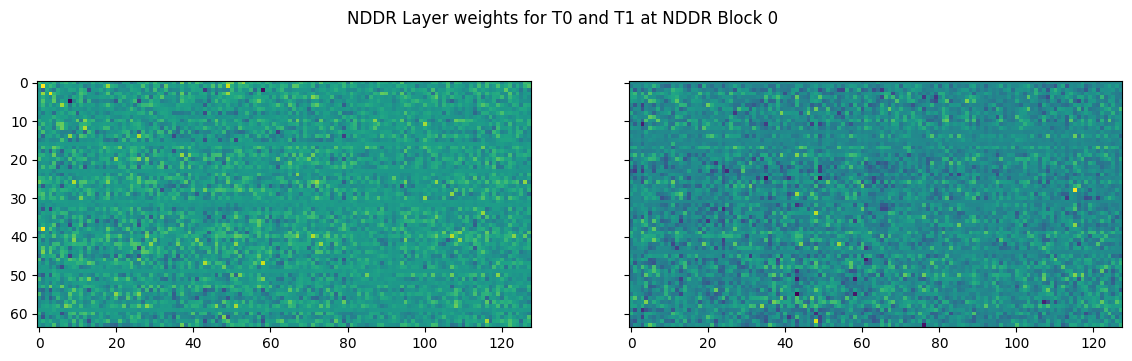

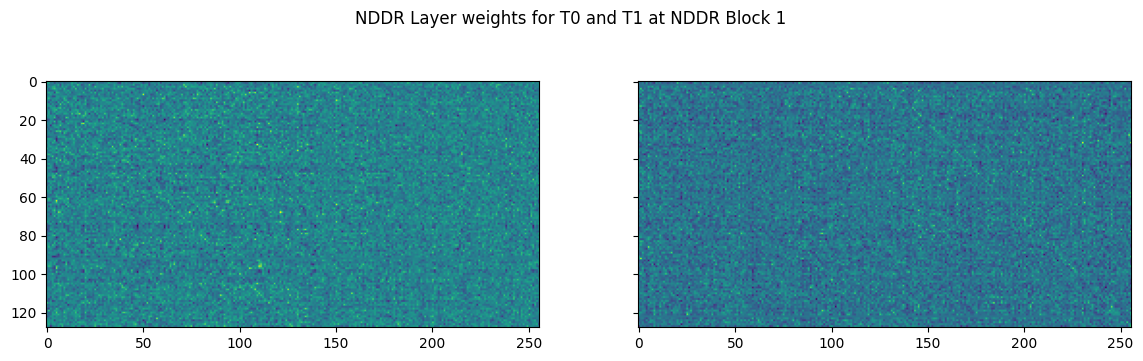

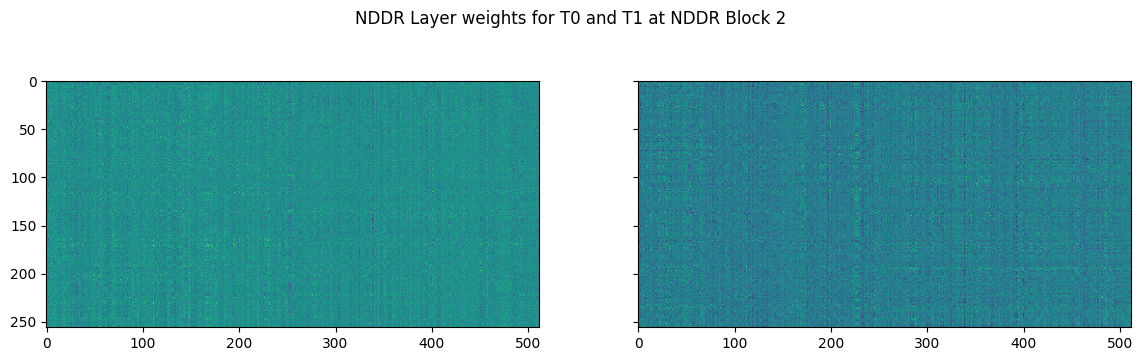

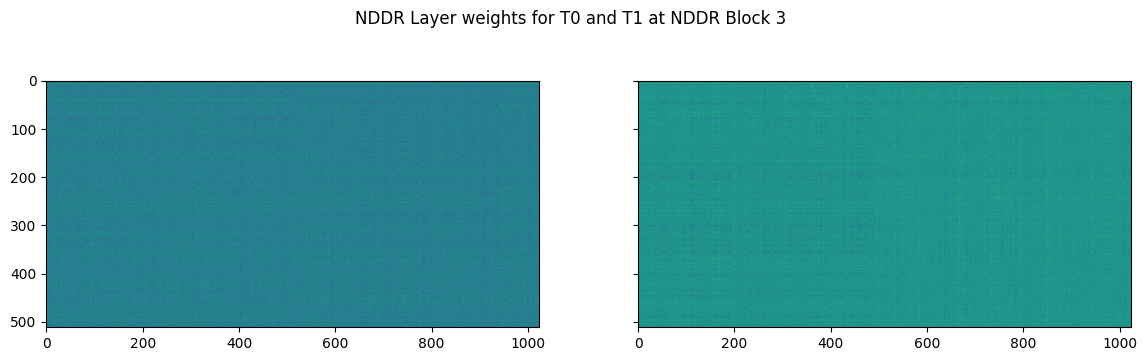

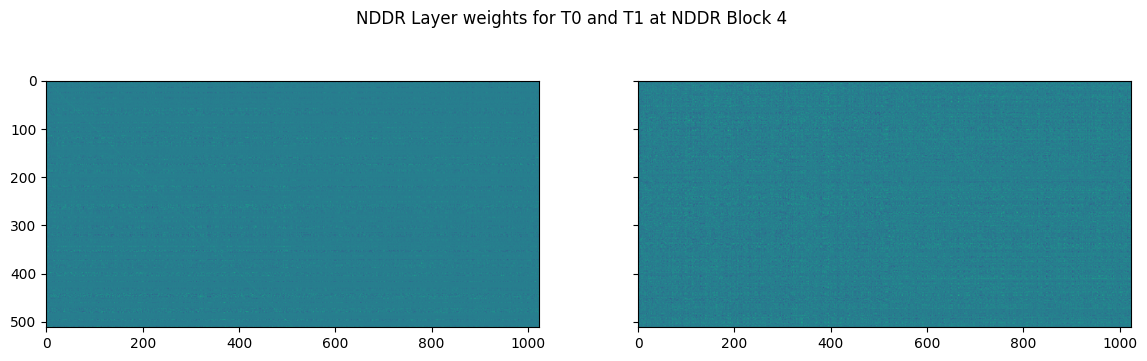

In [19]:
# Load the weights of the NDDR layer and show the average learned weights over the feature map
for i, ndrr_block in enumerate(model.nddrs):
    weights_t1 = ndrr_block.layer[0][0].weight.squeeze()
    weights_t2 = ndrr_block.layer[1][0].weight.squeeze()
    fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
    axs[0].imshow(weights_t1.detach().numpy())
    axs[1].imshow(weights_t2.detach().numpy())
    fig.suptitle(f'NDDR Layer weights for T0 and T1 at NDDR Block {i}')
    plt.show()


2D latent space visualization

In [27]:
# Vizualize the latent space in low dimensionality to understand if there is separation between the extracted features and the produced features for each task
nddrs_fts1, nddrs_fts2, y_age, y_gender = [], [], [], []
model.eval()
for i in tqdm(range(args_n_iters), total=args_n_iters):
    with torch.no_grad():
        batch = next(iter(trainloader))
        x, y = batch[0], batch[1]
        gender_lbl = y[:, 1].detach().numpy()
        age_lbl = y[:, 0].detach().numpy()
        for i, ndrr_block in enumerate(model.nddrs):
            if i == 0:
                ft1, ft2 = model.vgg_t1[i](x), model.vgg_t2[i](x)
            else:
                ft1, ft2 = model.vgg_t1[i](ft1), model.vgg_t2[i](ft2)

            # NDDR features
            nddr_ft1, nddr_ft2 = ndrr_block([ft1, ft2])

        nddr_ft1, nddr_ft2 = nddr_ft1.detach().numpy(), nddr_ft2.detach().numpy()
        nddrs_fts1.append(nddr_ft1)
        nddrs_fts2.append(nddr_ft2)
        y_age.append(age_lbl)
        y_gender.append(gender_lbl)

100%|██████████| 300/300 [11:59<00:00,  2.40s/it]


In [28]:
nddrs_fts1 = np.vstack(nddrs_fts1)
nddrs_fts2 = np.vstack(nddrs_fts2)
y_age = np.hstack(y_age)
y_gender = np.hstack(y_gender)

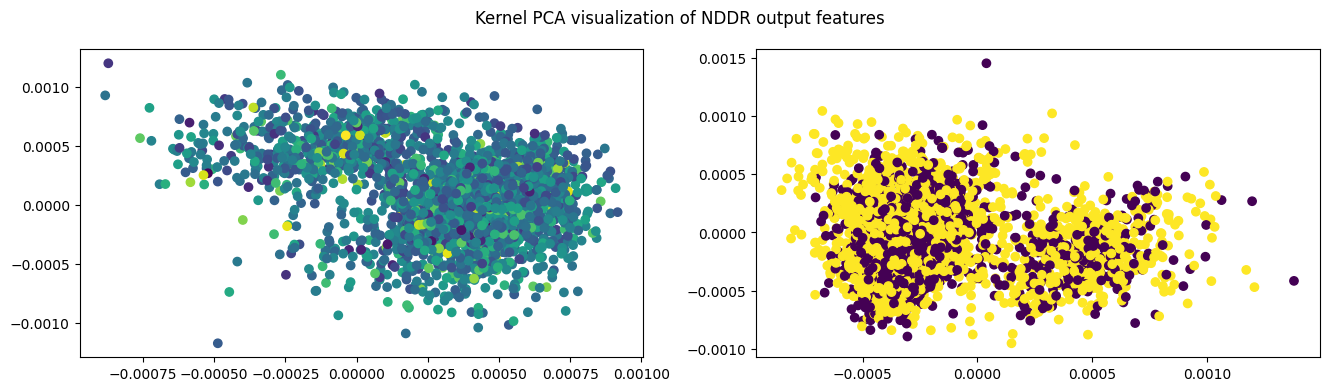

In [29]:
nddr_pca1, nddr_pca2 = KernelPCA(n_components=2, kernel='rbf'), KernelPCA(n_components=2, kernel='rbf')
pca_ft1 = nddr_pca1.fit_transform(nddrs_fts1.reshape(args_batch_size*args_n_iters, -1))
pca_ft2 = nddr_pca2.fit_transform(nddrs_fts2.reshape(args_batch_size*args_n_iters, -1))

# Kernel PCA
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].scatter(pca_ft1[:, 0], pca_ft1[:, 1], c=y_age)
axs[1].scatter(pca_ft2[:, 0], pca_ft2[:, 1], c=y_gender)
fig.suptitle(f'Kernel PCA visualization of NDDR output features')
plt.show()


--------------------------------------------------------------------------------
TSNE(metric='cosine', n_jobs=2, perplexity=50, random_state=21, verbose=True)
--------------------------------------------------------------------------------
===> Finding 150 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 157.04 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.13 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 1.19 seconds
===> Running optimization with exaggeration=12.00, lr=250.00 for 250 iterations...
Iteration   50, KL divergence 3.7047, 50 iterations in 0.6552 sec
Iteration  100, KL divergence 3.5725, 50 iterations in 0.4412 sec
Iteration  150, KL divergence 3.5619, 50 iterations in 0.4051 sec
Iteration  200, KL divergence 3.5623, 50 iterations in 0.3810 sec
Iteration  250, KL divergence 3.5619, 50 iterations in 0.4218 sec
   --> Time elapsed: 2.30 seconds
===> Running optimization with exagge

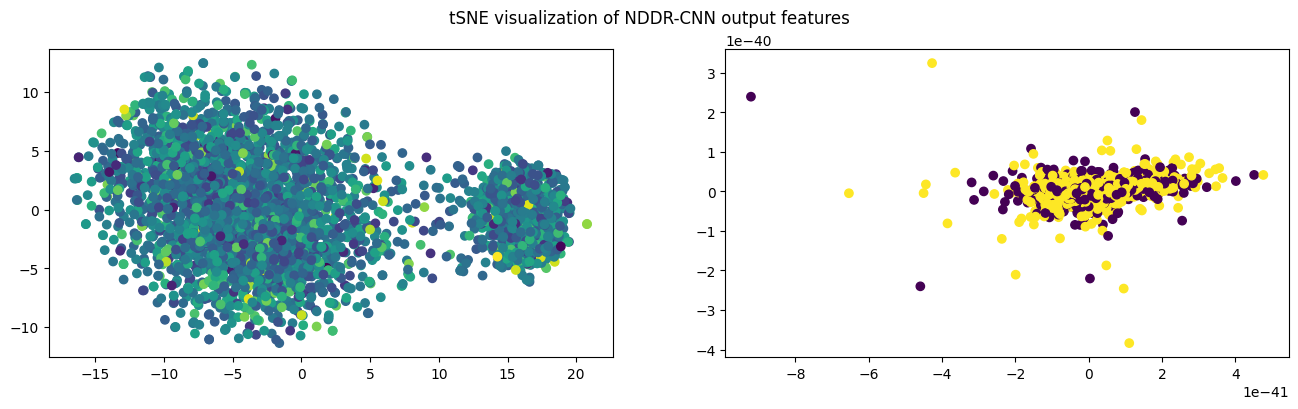

In [31]:
tsne_ft1 = otsne(metric='cosine', learning_rate='auto', perplexity=50, n_jobs=2, random_state=args_seed, verbose=True)
tsne_ft2 = otsne(metric='cosine', learning_rate='auto', perplexity=50, n_jobs=2, random_state=args_seed, verbose=True)
tsned_ft1 = tsne_ft1.fit(nddrs_fts1.reshape(args_batch_size*args_n_iters, -1))
tsned_ft2 = tsne_ft2.fit(nddrs_fts2.reshape(args_batch_size*args_n_iters, -1))

# TSNE
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].scatter(tsned_ft1[:, 0], tsned_ft1[:, 1], c=y_age)
axs[1].scatter(tsned_ft2[:, 0], tsned_ft2[:, 1], c=y_gender)
fig.suptitle(f'tSNE visualization of NDDR-CNN output features')
plt.show()


3D latent space visualization

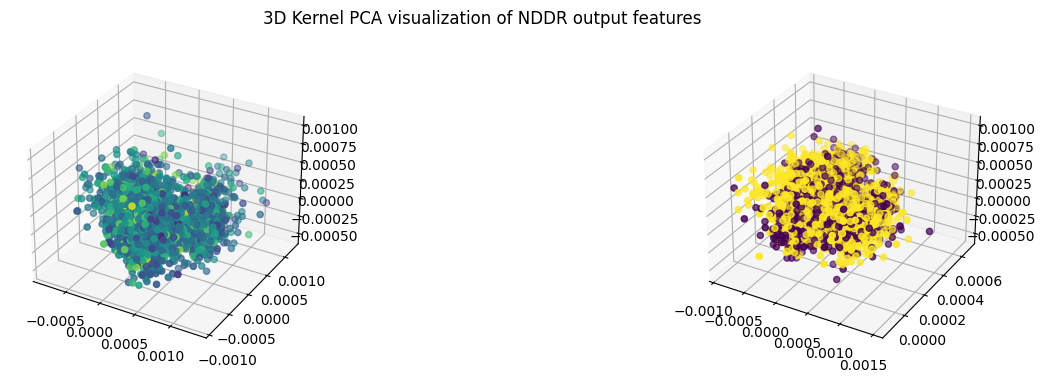

In [33]:
nddr_pca1, nddr_pca2 = KernelPCA(n_components=3, kernel='rbf'), KernelPCA(n_components=3, kernel='rbf')
pca_ft1 = nddr_pca1.fit_transform(nddrs_fts1.reshape(args_batch_size*args_n_iters, -1))
pca_ft2 = nddr_pca2.fit_transform(nddrs_fts2.reshape(args_batch_size*args_n_iters, -1))

# Kernel PCA
fig, axs = plt.subplots(1, 2, figsize=(16, 4), subplot_kw=dict(projection='3d'))
axs[0].scatter(pca_ft1[:, 0], pca_ft1[:, 1], pca_ft1[:, 2], c=y_age)
axs[1].scatter(pca_ft2[:, 0], pca_ft2[:, 1],  pca_ft1[:, 2], c=y_gender)
fig.suptitle(f'3D Kernel PCA visualization of NDDR output features')
plt.show()
